<a href="https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/1_getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Baselines3 Tutorial - Getting Started

Github repo: https://github.com/araffin/rl-tutorial-jnrr19/tree/sb3/

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines3.readthedocs.io/en/master/

SB3-Contrib: https://github.com/Stable-Baselines-Team/stable-baselines3-contrib

RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo

[RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) is a training framework for Reinforcement Learning (RL), using Stable Baselines3.

It provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos.


## Introduction

In this notebook, you will learn the basics for using stable baselines library: how to create a RL model, train it and evaluate it. Because all algorithms share the same interface, we will see how simple it is to switch from one algorithm to another.


## Install Dependencies and Stable Baselines3 Using Pip

List of full dependencies can be found in the [README](https://github.com/DLR-RM/stable-baselines3).


```
pip install stable-baselines3[extra]
```

In [ ]:
# for autoformatting
# %load_ext jupyter_black

In [17]:
!brew install ffmpeg freeglut xvfb  # For visualization
# !pip install "stable-baselines3[extra]>=2.0.0a4"

==> Searching for similarly named formulae and casks...
Error: No formulae or casks found for xvfb.


## Imports

Stable-Baselines3 works on environments that follow the [gym interface](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html).
You can find a list of available environment [here](https://gymnasium.farama.org/environments/classic_control/).

Not all algorithms can work with all action spaces, you can find more in this [recap table](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html)

In [2]:
import gymnasium as gym
import numpy as np

The first thing you need to import is the RL model, check the documentation to know what you can use on which problem

In [3]:
from stable_baselines3 import PPO

The next thing you need to import is the policy class that will be used to create the networks (for the policy/value functions).
This step is optional as you can directly use strings in the constructor: 

```PPO('MlpPolicy', env)``` instead of ```PPO(MlpPolicy, env)```

Note that some algorithms like `SAC` have their own `MlpPolicy`, that's why using string for the policy is the recommended option.

In [4]:
from stable_baselines3.ppo.policies import MlpPolicy

## Create the Gym env and instantiate the agent

For this example, we will use CartPole environment, a classic control problem.

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. "

Cartpole environment: [https://gymnasium.farama.org/environments/classic_control/cart_pole/](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)


We chose the MlpPolicy because the observation of the CartPole task is a feature vector, not images.

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space

Here we are using the [Proximal Policy Optimization](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) algorithm, which is an Actor-Critic method: it uses a value function to improve the policy gradient descent (by reducing the variance).

It combines ideas from [A2C](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://stable-baselines.readthedocs.io/en/master/modules/trpo.html) (it uses a trust region to improve stability and avoid catastrophic drops in performance).

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), [SAC](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html) or [TD3](https://stable-baselines3.readthedocs.io/en/master/modules/td3.html), but is much faster regarding wall-clock time.


In [5]:
env = gym.make("CartPole-v1")

model = PPO(MlpPolicy, env, verbose=0)

We create a helper function to evaluate the agent:

In [6]:
from stable_baselines3.common.base_class import BaseAlgorithm


def evaluate(
    model: BaseAlgorithm,
    num_episodes: int = 100,
    deterministic: bool = True,
) -> float:
    """
    Evaluate an RL agent for `num_episodes`.

    :param model: the RL Agent
    :param env: the gym Environment
    :param num_episodes: number of episodes to evaluate it
    :param deterministic: Whether to use deterministic or stochastic actions
    :return: Mean reward for the last `num_episodes`
    """
    # This function will only work for a single environment
    vec_env = model.get_env()
    obs = vec_env.reset()
    all_episode_rewards = []
    for _ in range(num_episodes):
        episode_rewards = []
        done = False
        # Note: SB3 VecEnv resets automatically:
        # https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api
        # obs = vec_env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            # `deterministic` is to use deterministic actions
            action, _states = model.predict(obs, deterministic=deterministic)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, _info = vec_env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print(f"Mean reward: {mean_episode_reward:.2f} - Num episodes: {num_episodes}")

    return mean_episode_reward

Let's evaluate the un-trained agent, this should be a random agent.

In [7]:
# Random Agent, before training
mean_reward_before_train = evaluate(model, num_episodes=100, deterministic=True)

Mean reward: 24.24 - Num episodes: 100


Stable-Baselines already provides you with that helper:

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy

In [9]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100, warn=False)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward: 23.99 +/- 10.92


## Train the agent and evaluate it

In [10]:
# Train the agent for 10000 steps
model.learn(total_timesteps=10_000)

In [11]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/Users/savan/.pyenv/versions/3.11.4/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:445.11 +/- 93.82


Apparently the training went well, the mean reward increased a lot ! 

### Prepare video recording

In [12]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

sh: Xvfb: command not found


In [13]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [18]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

### Visualize trained agent



In [19]:
record_video("CartPole-v1", model, video_length=500, prefix="ppo-cartpole")

t:   0%|          | 1/501 [02:46<23:10:13, 166.83s/it, now=None]

Saving video to /Users/savan/Documents/UofG/MSc Project/Code/rl-tutorial-jnrr19-sb3/videos/ppo-cartpole-step-0-to-step-500.mp4
Moviepy - Building video /Users/savan/Documents/UofG/MSc Project/Code/rl-tutorial-jnrr19-sb3/videos/ppo-cartpole-step-0-to-step-500.mp4.
Moviepy - Writing video /Users/savan/Documents/UofG/MSc Project/Code/rl-tutorial-jnrr19-sb3/videos/ppo-cartpole-step-0-to-step-500.mp4



OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file /Users/savan/Documents/UofG/MSc Project/Code/rl-tutorial-jnrr19-sb3/videos/ppo-cartpole-step-0-to-step-500.mp4:

 b"Unrecognized option 'preset'.\nError splitting the argument list: Option not found\n"

In [ ]:
show_videos("videos", prefix="ppo")

## Bonus: Train a RL Model in One Line

The policy class to use will be inferred and the environment will be automatically created. This works because both are [registered](https://stable-baselines3.readthedocs.io/en/master/guide/quickstart.html).

In [ ]:
model = PPO('MlpPolicy', "CartPole-v1", verbose=1).learn(1000)

## Conclusion

In this notebook we have seen:
- how to define and train a RL model using stable baselines3, it takes only one line of code ;)

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -52.89
Saving new best model to tmp/best_model
Num timesteps: 2000
Best mean reward: -52.89 - Last mean reward per episode: 446.34
Saving new best model to tmp/best_model
Num timesteps: 3000
Best mean reward: 446.34 - Last mean reward per episode: -335.50
Num timesteps: 4000
Best mean reward: 446.34 - Last mean reward per episode: -666.75
Num timesteps: 5000
Best mean reward: 446.34 - Last mean reward per episode: -706.12
Num timesteps: 6000
Best mean reward: 446.34 - Last mean reward per episode: -577.29
Num timesteps: 7000
Best mean reward: 446.34 - Last mean reward per episode: -461.60
Num timesteps: 8000
Best mean reward: 446.34 - Last mean reward per episode: -347.89
Num timesteps: 9000
Best mean reward: 446.34 - Last mean reward per episode: -252.84
Num timesteps: 10000
Best mean reward: 446.34 - Last mean reward per episode: -180.06
Num timesteps: 11000
Best mean reward: 446.34 - Last mean reward per epis

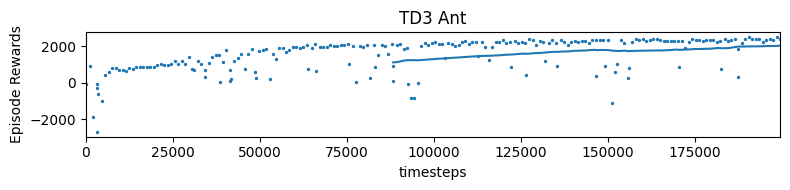

In [24]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "timesteps")
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
# env = gym.make("LunarLanderContinuous-v2")

env = gym.make("Ant-v4")
env = Monitor(env, log_dir)

# Add some action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=0)
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Train the agent
timesteps = 2e5
model.learn(total_timesteps=int(timesteps), callback=callback)

plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "TD3 Ant")
plt.show()

In [26]:
# model = TD3.load("sac_ant", env=env)

# Evaluate the agent
# NOTE: If you use wrappers with your environment that modify rewards,
#       this will be reflected here. To evaluate with original rewards,
#       wrap environment in a "Monitor" wrapper before other wrappers.
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

# Enjoy trained agent
vec_env = model.get_env()
obs = vec_env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render("human")

/Users/savan/.pyenv/versions/3.11.4/lib/python3.11/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:215: UserWarning: Starting from gymnasium v0.26, render modes are determined during the initialization of the environment.
                We allow to pass a mode argument to maintain a backwards compatible VecEnv API, but the mode (rgb_array)
                has to be the same as the environment render mode (None) which is not the case.
  warnings.warn(


: 